# Object Localisatie

In dit notebook gaan we twee kernconcepten van computer vision implementeren: object localisatie en object detectie. We zullen deze oefeningen uitvoeren met behulp van zowel PyTorch als Keras, en we gebruiken zowel zelf te trainen netwerken als pre-trained netwerken om de taken te voltooien. Object localisatie is gericht op het vinden van de positie van een enkel object in een afbeelding, terwijl object detectie het vinden van meerdere objecten met hun bijbehorende klassen omvat.

In [40]:
import os
import xml.etree.ElementTree as ET
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import opendatasets as od
import numpy as np

od.download("https://www.kaggle.com/datasets/mbkinaci/image-localization-dataset")

# Helper Functies
def imshow(img, title=None):
    """Toont een afbeelding."""
    npimg = img.numpy() if isinstance(img, torch.Tensor) else img
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

def show_image_with_bbox(image, bbox, title=None):
    """Toont een afbeelding met een bounding box."""
    npimg = image.numpy() if isinstance(image, torch.Tensor) else image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    img_size = npimg.shape[1]
    xmin = bbox[0] * img_size
    ymin = bbox[1] * img_size
    width = bbox[2] * img_size
    height = bbox[3] * img_size
    print(xmin, ymin, width, height)
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), width, height,
                                      fill=False, edgecolor='red', linewidth=2))
    if title:
        plt.title(title)
    plt.show()

Skipping, found downloaded files in "./image-localization-dataset" (use force=True to force download)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.016206061..1.0000002].


tensor(5.6243) tensor(-3.6786) tensor(-4.5059) tensor(3.0776)


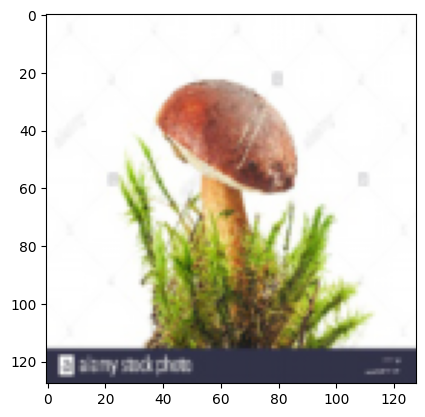

In [41]:
show_image_with_bbox(image[0], outputs[0].detach())

## Oefening 1: Object Localisatie met PyTorch

In deze oefening gebruiken we PyTorch om een eenvoudig neuraal netwerk te trainen voor object localisatie. Het doel van object localisatie is om de coördinaten van de bounding box rondom een enkel object in een afbeelding te voorspellen. We maken een convolutioneel neuraal netwerk (CNN) dat leert om vier waarden te voorspellen: de x- en y-coördinaten van de bovenste linkerhoek van de bounding box, en de breedte en hoogte van de box. 

We gebruiken een dummy dataset van willekeurige afbeeldingen en trainen het model om één bounding box te voorspellen voor elke afbeelding.

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Zet de afbeelding om naar een tensor en normaliseer naar [0, 1]
    transforms.Resize((128,128))
])

# custom dataset aanmaken
class XMLDataset(Dataset):
    def __init__(self, root_dir, transform=None, img_size=128):
        self.root_dir = root_dir
        self.transform = transform
        self.img_size=img_size

        self.images=[f for f in os.listdir(self.root_dir) if f.endswith(".jpg")]
        pass

    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        # read image
        img_path = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        # extract bbox
        xml_path = os.path.splitext(img_path)[0] + '.xml' # vervang .jpg door .xml
        tree = ET.parse(xml_path)
        root = tree.getroot() # parse xml file

        width = float(root.find('size/width').text)
        height = float(root.find('size/height').text)
        
        bbox = root.find('object/bndbox')
        xmin = float(bbox.find('xmin').text) # haal de waarde uit de node op
        xmax = float(bbox.find('xmax').text)
        ymin = float(bbox.find('ymin').text)
        ymax = float(bbox.find('ymax').text)

        # preprocess bbox
        # zet het om naar x en y linkerboven hoek en breedte/hoogte van de bbxo
        # zet het om naar percentages
        bbox = [xmin/width, ymin/height, (xmax-xmin)/width, (ymax-ymin)/height]
        
        # return image,bbox
        return image, torch.tensor(bbox, dtype=torch.float32)

dataset = XMLDataset(root_dir='./image-localization-dataset/training_images', transform=transform, img_size=128)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [15]:
model = nn.Sequential(
    #convolutioneel gedeelte
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1), # out_channels kan je kiezen, typisch wordt dit groter als je dieper in het netwerk gaat
    nn.ReLU(), # de activatiefunctie!
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1), # in_channels gelijk aan out_channels vorige
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1), 
    nn.ReLU(),
    nn.MaxPool2d(2),
    #Flatten (maak er 1d van van elk figuur)
    nn.Flatten(),
    #Fully connected gedeelte
    nn.Linear(16384, 128),  # 16384 te berekenen door het model eens uit te voeren tot de flatten of 16*16*64
    nn.ReLU(),
    nn.Linear(128, 4)
)

for image,target in dataloader:
    print(model(image).shape)
    break

torch.Size([8, 4])


In [42]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for image,target in dataloader:
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, target)
        loss.backward()
        epoch_loss+= loss.item()

    print(f"Epoch {epoch}: running loss is {epoch_loss / len(dataloader)}")

Epoch 0: running loss is 0.2535681662460168
Epoch 1: running loss is 0.252726669733723
Epoch 2: running loss is 0.2522519708921512
Epoch 3: running loss is 0.25357656242946786
Epoch 4: running loss is 0.25186921656131744
Epoch 5: running loss is 0.2531243910392125
Epoch 6: running loss is 0.2560509579877059
Epoch 7: running loss is 0.25306685268878937
Epoch 8: running loss is 0.25407716321448487
Epoch 9: running loss is 0.2541838865727186


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0001548311..1.0000002].


tensor([0.2423, 0.1322, 0.4934, 0.8018])
tensor([ 0.0429, -0.0248, -0.0355,  0.0228], grad_fn=<SelectBackward0>)
tensor(31.0132) tensor(16.9163) tensor(63.1542) tensor(102.6255)


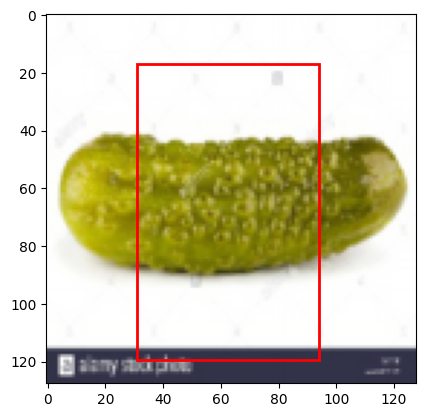

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0001548311..1.0000002].


tensor(5.4867) tensor(-3.1706) tensor(-4.5457) tensor(2.9182)


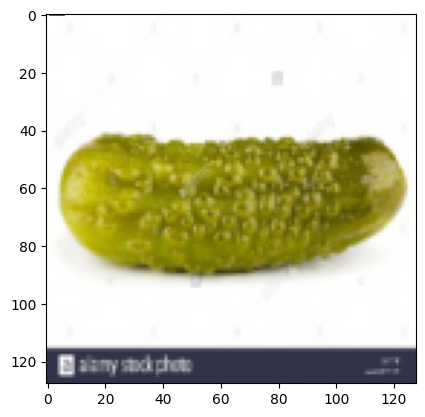

In [43]:
images,targets = next(iter(dataloader))
outputs = model(images)

print(targets[0])
print(outputs[0])

show_image_with_bbox(image[0], targets[0])
show_image_with_bbox(image[0], outputs[0].detach())

## Oefening 2: Object Detectie met PyTorch

In deze oefening gebruiken we PyTorch om object detectie uit te voeren met een pre-trained Faster R-CNN-model. Faster R-CNN (Region-Based Convolutional Neural Network) is een state-of-the-art model voor object detectie dat zowel de bounding boxes als de klassen van meerdere objecten in een afbeelding kan voorspellen.

We maken gebruik van een pre-trained Faster R-CNN-model dat beschikbaar is via de `torchvision` bibliotheek. Dit model is al getraind op de COCO dataset, dus we kunnen het gebruiken om objecten in nieuwe afbeeldingen te detecteren zonder aanvullende training.

In [1]:
import torch
import torchvision
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

# Define helper function to display image with bounding boxes
def show_image_with_bboxes(image, bboxes, title=None):
    """Displays an image with bounding boxes."""
    plt.imshow(F.to_pil_image(image))  # Convert tensor image to PIL image for displaying
    ax = plt.gca()  # Get the current axes instance on the current figure
    
    # Draw all bounding boxes
    for bbox in bboxes.detach():
        x_min, y_min, x_max, y_max = bbox
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                             fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

    if title:
        plt.title(title)
    plt.show()

# Define the transform to convert the image to a tensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# Load the single image
image_path = 'object-detection/img1.jpg'  # Path to your image file
image = Image.open(image_path).convert('RGB')  # Open the image file and ensure it's in RGB mode

# Apply the transformation
image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension


# LOAD THE MODEL
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

/opt/conda/lib/python3.10/site-packages/torchvision/utils.py:223: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


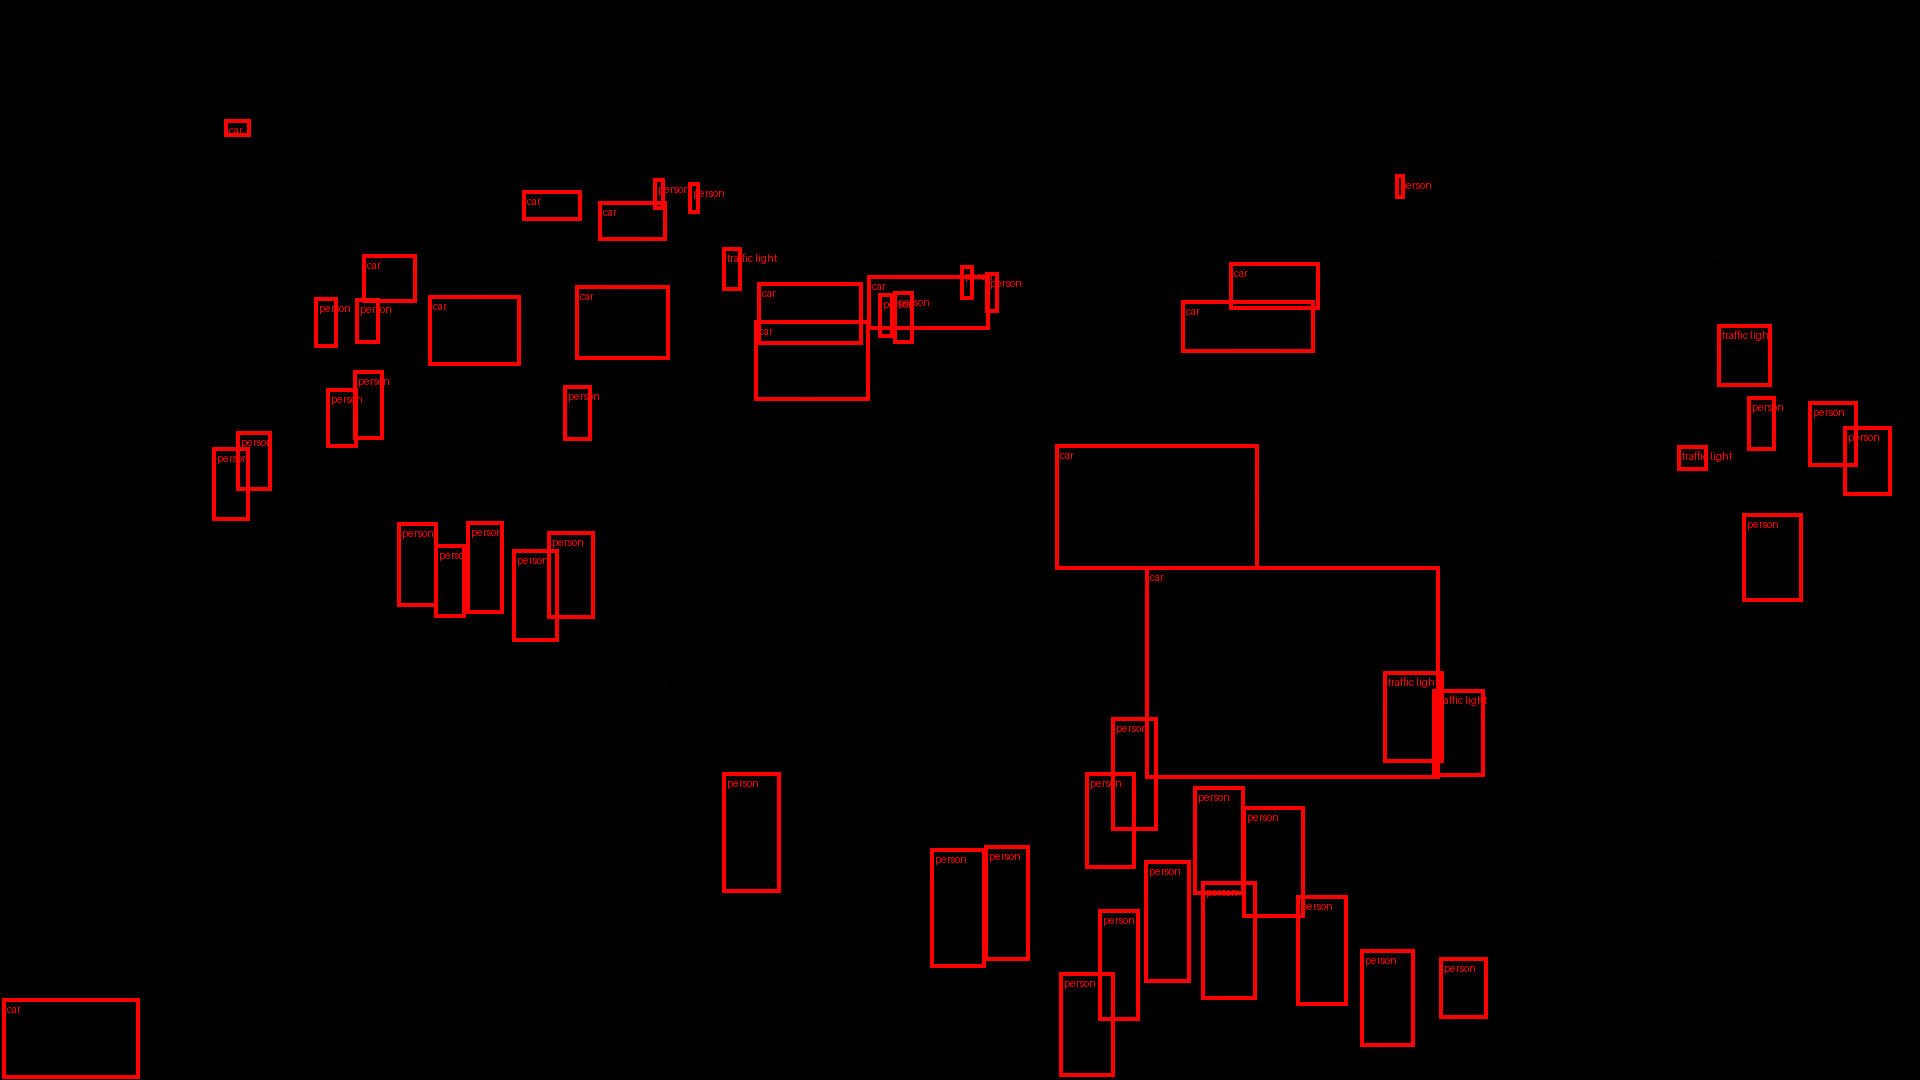

In [7]:

from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

prediction = model(image_tensor)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(image_tensor.type(torch.uint8)[0], boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)
im = to_pil_image(box.detach())
im.show()

## Oefening 3: Object Localisatie met Keras

In deze oefening implementeren we object localisatie met Keras. Net als in Oefening 1 bouwen we een eenvoudig CNN-model dat leert om de coördinaten van een bounding box te voorspellen voor een enkel object in een afbeelding. Dit model wordt getraind op een dummy dataset met willekeurige afbeeldingen en dummy bounding box-coördinaten.

Het model bestaat uit een reeks convolutie- en poolinglagen, gevolgd door volledig verbonden lagen die de bounding box-coördinaten voorspellen. We gebruiken Mean Squared Error (MSE) als de verliesfunctie om de coördinaten te trainen.